In [114]:
import sys
import os
import numpy as np
import pandas as pd

variants_file = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/raw/all_variants_pvalues_tejaas.txt"
variants_df = pd.read_csv(variants_file, sep="\t", header=0, index_col=0)
variants_df.drop("gtex_v8-bl", axis=1, inplace=True)

In [115]:
shapeit_file = "/cbscratch/franco/from_saikat/gtex_v8_202003/all_variants_pvalues_tejaas.txt"
shapeit_df = pd.read_csv(shapeit_file, sep="\t", header=0, index_col=0)

In [116]:
# Collect best p-val for each variant across all 49 tissues
best_pvals = np.max(variants_df, axis=1)
best_pvals_shapeit = np.max(shapeit_df, axis=1)

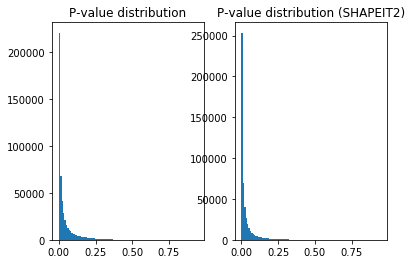

In [118]:
import matplotlib.pyplot as plt

nchoose = 500000
idx = np.sort(np.random.choice(len(best_pvals), nchoose, replace = False))
pvals = [np.power(10, -best_pvals.values[i]) for i in idx]

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.hist(pvals, bins=100)
ax1.set_title("P-value distribution")


nchoose = 500000
idx = np.sort(np.random.choice(len(best_pvals_shapeit), nchoose, replace = False))
pvals_shapeit = [np.power(10, -best_pvals_shapeit.values[i]) for i in idx]

ax2 = fig.add_subplot(122)
ax2.hist(pvals_shapeit, bins=100)
ax2.set_title("P-value distribution (SHAPEIT2)")
plt.show()

# Load dbSNP and GWAS catalog

In [119]:
import gzip 

dbsnp_dict = dict()
with gzip.open("/cbscratch/franco/datasets/gtex_v8/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.lookup_table.txt.gz") as instream:
    next(instream)
    for line in instream:
        arr = line.decode().rstrip().split()
        #if len(arr[3]) == 1 and len(arr[4]) == 1:
        dbsnp_dict[arr[2]] = arr[6]

In [120]:
import collections
import re 
gwas_cat = "/cbscratch/franco/datasets/GWAScatalog/gwas_catalog_v1.0-associations_e98_r2019-12-16.tsv"
gwas_pos_dict = collections.defaultdict(dict)
skip = 0
loaded = 0
weird_snps = list()
gwas_rsid_dict = collections.defaultdict(lambda: False)
gwas_rsid_trait = dict()
gwas_rsid_list = list()
with open(gwas_cat) as instream:
    header = instream.readline().rstrip().split("\t")
    # header[17] SNP_GENE_IDS
    print( header[7], header[11], header[12], header[21], header[22], header[23], header[27])
    for line in instream:
        arr = line.rstrip().split("\t")
        # df_gwas.iloc[:,[12,23,27]]
        trait = arr[7]
        chrm  = arr[11]
        bp_pos= arr[12]
        snps  = arr[21]
        snp_id_current = arr[23]
        pval  = arr[27]
        if re.search(";", snps):
            bp_pos_arr = bp_pos.split(";")
            snps_arr   = snps.split(";")
            chrm_arr   = chrm.split(";")
            # print(bp_pos_arr, snps_arr)
            if len(bp_pos_arr) != len(snps_arr) and len(snps_arr) != len(chrm_arr):
                if len(bp_pos_arr) == len(chrm_arr):
                    new_snps_arr = [s.strip() for s in snps_arr if s.strip().startswith('rs')]
                    if len(new_snps_arr) == len(bp_pos_arr):
#                         print("good!", new_snps_arr, bp_pos_arr, chrm_arr)
                        for i in range(len(new_snps_arr)):
                            gwas_rsid_list.append(new_snps_arr[i])
                            gwas_pos_dict[chrm_arr[i]][bp_pos_arr[i]] = new_snps_arr[i]
                            loaded += 1
                    else:
#                         print("wtf!", snps_arr, new_snps_arr, bp_pos_arr, chrm_arr)
                        skip += 1
                else:
                    skip += 1
                    print(bp_pos_arr, snps_arr, chrm_arr)
                    weird_snps.append((bp_pos_arr, snps_arr, chrm_arr))
                    continue
            else:
                for s in snps_arr:
                    if s.strip().startswith('rs'):
                        gwas_rsid_dict[s.strip()] = True
                        gwas_rsid_trait[s.strip()] = trait
                        gwas_rsid_list.append(s.strip())
                        loaded += 1
                    else:
                        pass
#                         print("WTF, ",s)
            if len(bp_pos_arr) == len(snps_arr) and len(snps_arr) == len(chrm_arr):
                for i in range(len(snps_arr)):
                    gwas_pos_dict[chrm_arr[i]][bp_pos_arr[i]] = snps_arr[i]
                    loaded += 1
        else:
            if snps.startswith('rs'):
                gwas_rsid_dict[snps] = True
                gwas_rsid_trait[snps] = trait
                gwas_rsid_list.append(snps)
                gwas_pos_dict[chrm][bp_pos] = snps
                loaded += 1
            else:
                pass
                # print("not rs snp?!", snps, chrm, bp_pos)
print("Skipped {:d} GWAS snps".format(skip))
print("{:d} GWAS SNPs loaded".format(loaded))

DISEASE/TRAIT CHR_ID CHR_POS SNPS MERGED SNP_ID_CURRENT P-VALUE
Skipped 326 GWAS snps
182308 GWAS SNPs loaded


In [121]:
gwas_variants = list()
for variant_id in list(variants_df.index):
    dbsnp_id = dbsnp_dict.get(variant_id, False)
    if dbsnp_id and gwas_rsid_dict[dbsnp_id]:
        gwas_variants.append(variant_id)        
print("GTEx SNPs in GWAS catalog:", len(gwas_variants))
print("fraction of snps in GWAS:", len(gwas_variants)/variants_df.shape[0])

gwas_variants_shapeit = list()
for variant_id in list(shapeit_df.index):
    dbsnp_id = dbsnp_dict.get(variant_id, False)
    if dbsnp_id and gwas_rsid_dict[dbsnp_id]:
        gwas_variants_shapeit.append(variant_id)
print("GTEx SNPs in GWAS catalog (SHAPEIT2):", len(gwas_variants_shapeit))
print("fraction of snps in GWAS (SHAPEIT2):", len(gwas_variants_shapeit)/shapeit_df.shape[0])

# SNPs in GWAS catalog: 95512
# GTEx SNPs in GWAS catalog: 35452
# Total nº of GTEx SNPS: 4522283
# fraction of snps in GWAS: 0.007839403239469975

GTEx SNPs in GWAS catalog: 40661
fraction of snps in GWAS: 0.00899125508067496
GTEx SNPs in GWAS catalog (SHAPEIT2): 79461
fraction of snps in GWAS (SHAPEIT2): 0.009872581195243181


In [122]:
gwas_variants_pvals = best_pvals.loc[gwas_variants]
gwas_variants_pvals_shapeit = best_pvals_shapeit.loc[gwas_variants_shapeit]

In [123]:
# Get proportions for all pvals
mt_cutoff = 0.05/49
cutoffs = -np.log10(np.array([1, 0.1, 0.05, 0.01, mt_cutoff, 1e-4, 1e-5] + [np.power(10.0, -i) for i in range(6,15)]))
#cutoffs = np.linspace(-np.log10(0.05), -np.log10(1e-20), 100)
fractions = list()
fractions_shapeit = list()
for c in cutoffs:
    pass_snps = np.sum(best_pvals > c)
    fractions.append( pass_snps / len(best_pvals))
    pass_snps = np.sum(best_pvals_shapeit > c)
    fractions_shapeit.append( pass_snps / len(best_pvals_shapeit))

In [134]:
# Get proportions for all GWAS pvals
fractions_gwas = list()
fractions_gwas_shapeit = list()
for c in cutoffs:
    pass_snps = np.sum(gwas_variants_pvals > c)
    fractions_gwas.append( pass_snps / len(gwas_variants_pvals))

    pass_snps = np.sum(gwas_variants_pvals_shapeit > c)
    fractions_gwas_shapeit.append( pass_snps / len(gwas_variants_pvals_shapeit))

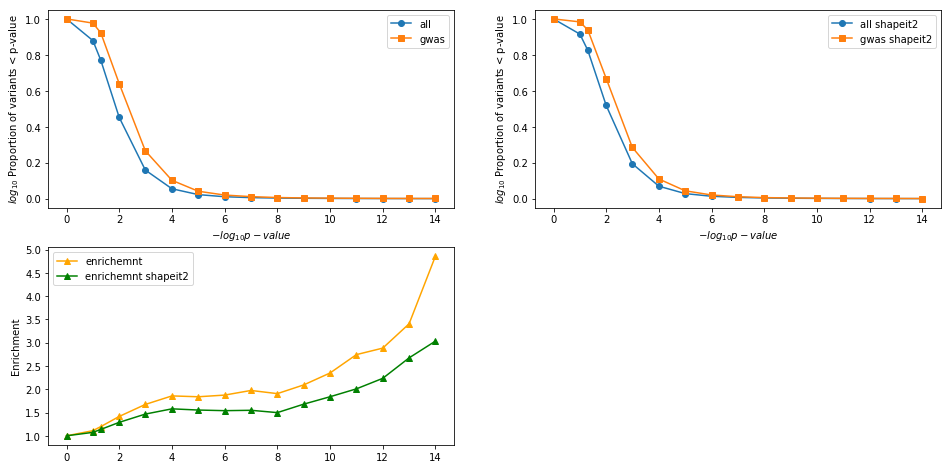

In [141]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(221)
ax1.plot(cutoffs, fractions, marker='o', label="all")
ax1.plot(cutoffs, fractions_gwas, marker='s', label="gwas")
ax1.set_xlabel("$-log_{10} p-value$")
ax1.set_ylabel("$log_{10}$ Proportion of variants < p-value")
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(cutoffs, fractions_shapeit, marker='o', label="all shapeit2")
ax2.plot(cutoffs, fractions_gwas_shapeit, marker='s', label="gwas shapeit2")
ax2.set_xlabel("$-log_{10} p-value$")
ax2.set_ylabel("$log_{10}$ Proportion of variants < p-value")
ax2.legend()


ax3 = fig.add_subplot(223)
ax3.plot(cutoffs, np.array(fractions_gwas) / np.array(fractions), marker='^', color="orange", label="enrichemnt")
ax3.set_ylabel("Enrichment")
ax3.legend()
# ax1.set_ylim(0,0.2)


# ax3 = fig.add_subplot(224)
ax3.plot(cutoffs, np.array(fractions_gwas_shapeit) / np.array(fractions_shapeit), marker='^', color="green", label="enrichemnt shapeit2")
ax3.set_ylabel("Enrichment")
ax3.legend()


plt.show()